<center>

# SymNet for Adversarial Domain Adaptation
## Deep Learning Assignment
### A.Y. 2021/22 - University of Trento 
#### Hrovatin Lucia e Miotto Luca

</center>

# Abstract


In this notebook, we tackle the Unsupervised Domain Adaptation (UDA) task on the reduced version of Adaptiope dataset ([Ringwald & Stiefelhagen](https://paperswithcode.com/dataset/adaptiope), 2021). This version considers the <code>real world</code> (<i>RW</i>) and <code>product</code> (<i>P</i>) domains and narrow down the classes to $20$.

Our solution is inspired by the <i>Domain-Symmetric Networks</i> (<i>SymNets</i>), proposed by [Zhang](https://arxiv.org/abs/1904.04663) <i>et al.</i> (2019), and suggests additional architectural refinements to overcome model overfitting and overconfidence.

The deployed version of the architecture outperforms both the external baseline (i.e., from the assignment description) and the internal one, namely the source-only model. However, it is worth noting how the <i>gain</i>'s magnitude varies depending on <code>source</code> and <code>target</code> domain definition, meaning the <i>direction</i> of the adaptation.  


# Environment Preparation

## Python Version

In [2]:
%%capture 

!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2
!python --version

## Import  Libraries

In [3]:
import os 
import json
import math
import torch
import torchvision
import shutil
import imagesize
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch.nn as nn
import torch.cuda as cuda
import torchvision.transforms as T
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from abc import abstractmethod
from tqdm import tqdm
from statistics import mean, stdev
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from torch import Tensor
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torch.nn import CrossEntropyLoss
from torch.optim import RMSprop, Adadelta, SGD
from google.colab import drive 

## Not supported in Colab, but explicit references among (sub)classes can be activated
#from overrides import overrides, final 

## HyperParameters

In [4]:
# Device Settings
seed = 42 # allow reproducibility of the results

# EDA
thre = 2 # threshold to check whether images are squared or almost squared

# Data Transformation
path = "./adaptiope_small/"
source = "real_life/"
target = "product_images/" 
resize_dim = 256 
crop_dim = 224 # size chosen due to ResNet 
grayscale = False 
crop_center = True

# Data Loader
batch_size = 30 # 15 might also be a reasonable choice given the small number of classes 
test_split = 0.2 # given by the assignment description

# Feature Extractor
n_classes = 20 # given by the assignment description
model = 'resnet50' # resnet18 has been tested as well 
optim = 'rmsprop' 
n_params_trained = 10 # result after fine-tuning 
weight_decay = 1e-4 # result after fine-tuning 
lr = 1e-2 # result after fine-tuning 
dropout = 0.5 # result after fine-tuning 
label_smoothing = 0.2 # result after fine-tuning 
source_only = False  

# Model Trainer
n_epochs = 250 # parameter set extremely high, but never reached
patience = 10 

## Device Settings

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda.is_available():
    print('You\'re running on GPU')
    cuda.manual_seed(seed)
    gpu = True
else:
    print('You\'re running on CPU')
    gpu = False

You're running on GPU


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 19 18:59:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    32W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
ram_gb = round(ram_gb, 2)
print(f'{ram_gb} GB of RAM\n')

27.33 GB of RAM



## Model Saver 

In [8]:
class ModelSaver:
    
    def __init__(self, base_dir: str, source_only=False):
        """
        The class saves the best running model as pickle file, along with its 
        results and parameters as json. 

        Parameters
        ----------
        base_dir: str
            directory to save the files 
        source_only: bool
            if True, it saves the results of the source only model
        
        Methods
        -------
        check_base_dir:
            Check whether the directory exists or not.  

        model_save:
            Save the best model and optimizer in a pickle file.
        
        save_hyperparam: 
            Save the list of hyperparameters employed 
            by the model in a json file.  

        save_results:         
            Save the model results (e.g., accuracy on train and validation)
            in a json file.  
        """
        self.base_dir = base_dir
        self.filename = source.split("_")[0] + "2" + target.split("_")[0]
        self.fullpath = f'{base_dir}/{self.filename}'
        self.source_only = source_only
    
    def check_base_dir(self):
        try:
            if not os.path.exists(self.base_dir):
                os.makedirs(self.base_dir)
            return True
        except OSError:
            return False

    def model_save(self, model, optimizer):
        # Save only if the base directory exists
        if self.check_base_dir(): 
            with open(f'{self.fullpath}.pickle', 'wb') as f:
                torch.save([model, optimizer], f)
        else:
            raise Exception('Model saving failed')
    
    def save_hyperparam(self):
        params_dict = {
            'seed': seed,
            'source': source,
            'target': target,
            'grayscale': grayscale,
            'crop_center': crop_center,
            'batch_size': batch_size,
            'test_split': test_split,
            'n_classes': n_classes,
            'model': model,
            'optimizer': optim,
            'n_params_trained': n_params_trained,
            'weight_decay': weight_decay,
            'learning_rate': lr,
            'dropout': dropout,
            'label_smoothing': label_smoothing,
            'n_epochs': n_epochs,
            'patience': patience
        }
        if self.check_base_dir():
            with open(f'{self.fullpath}_params.json', 'w') as f:
                json.dump(params_dict, f, indent=4)
        else:
            raise Exception('Hyperparams saving failed')
            
    def save_results(self, results: dict):
        if self.check_base_dir():
            if self.source_only:
                self.fullpath = self.fullpath + "_so"
            with open(f'{self.fullpath}_results.json', 'w') as f:
                json.dump(results, f, indent=4)
        else:
            raise Exception('Results saving failed')

# Data Collection

In [9]:
%%capture

drive.mount('/content/drive', force_remount=True)

if not os.path.exists('/content/adaptiope_small'):
  !mkdir "/content/dataset"
  
  try:
    !cp "/content/drive/My Drive/DLL_project/Adaptiope.zip" "/content/dataset/"
  except: 
    raise FileExistsError("Could not find this directory, add a shortcut to your drive")
  
  !ls "/content/dataset"
  !unzip "/content/dataset/Adaptiope.zip"
  !rm -rf "/content/adaptiope_small"
  !mkdir "/content/adaptiope_small"

In [10]:
# Filter Adaptiope dataset to extract the classes of interest 

classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  if not os.path.exists(td):
    os.makedirs(td)
    for c in tqdm(classes):
      c_path = os.path.join(d, c)
      c_target = os.path.join(td, c)
      shutil.copytree(c_path, c_target)

100%|██████████| 20/20 [00:00<00:00, 21.67it/s]


# Data Preparation

## Exploratory Data Analysis (EDA)

An Exploratory Data Analysis has been performed to learn about the data we are working with. Specifically, the metadata of each image has been extracted and saved into a dictionary(**metadata_img**). 

In [11]:
metadata_img = {}
domains = ["product_images", "real_life"]

for domain in domains:
  subclass = os.listdir(f"{path}{domain}")
  for cls_name in classes:
    imgs = [img.name for img in Path(f"{path}{domain}/{cls_name}/").iterdir() if img.suffix == ".jpg"]
    for img in imgs: 
      metadata_img[str(img + domain)] = imagesize.get(f"{path}{domain}/{cls_name}/"+img)

In [12]:
img_df = pd.DataFrame.from_dict([metadata_img]).T.reset_index().set_axis(['file_name', 'size'], axis='columns', inplace=False)

# store width and height in a Pandas data frame
img_df[["width", "height"]] = pd.DataFrame(img_df["size"].tolist(), index=img_df.index)

# define the domain of each image
img_df["domain"] = pd.DataFrame(img_df["file_name"].apply(lambda x: x[1:].split('.jpg')[-1]))

avg_width = round(img_df["width"].sum() / len(img_df))
avg_height = round(img_df["height"].sum() / len(img_df))
sd_width = round(stdev(img_df["width"]), 2)
sd_height = round(stdev(img_df["height"]), 2)

print(f'Height: avg = {avg_height} ± sd = {sd_height}')
print(f'Width: avg = {avg_width} ± sd = {sd_width}')

Height: avg = 1122 ± sd = 415.62
Width: avg = 1160 ± sd = 415.42


<center>

| Dimension| Average | Standard deviation | Minimum | Maximum |
|  :----: | :-----------: |:----------: |  :----: |  :----: | 
| Height | 1122 | 415.62| 75 | 2560|
| Width | 1160 | 415.42| 120| 2870|

</center>

The high standard deviations and discrepancies between extremes (i.e., <i>min</i> and <i>max</i>) stress the need for further analyses. Thus, several insights can be gained by displaying the underlying distributions of <i>height</i> and <i>width</i>. 

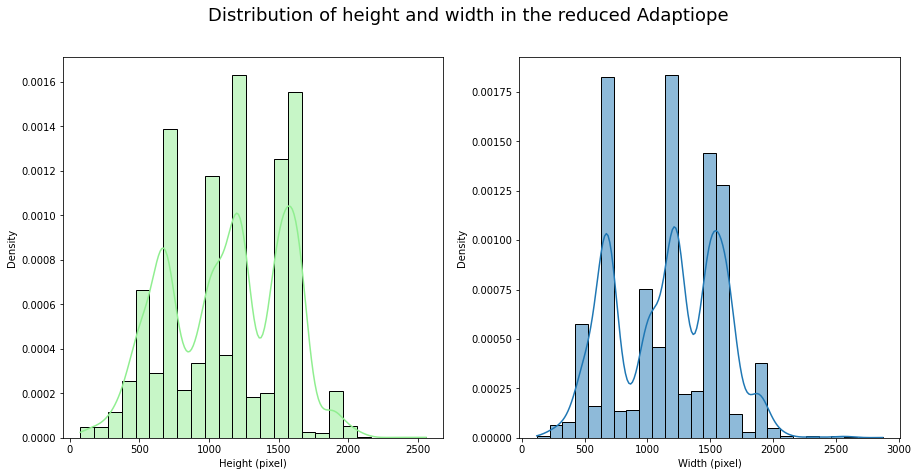

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
fig.suptitle("Distribution of height and width in the reduced Adaptiope", 
             fontsize=18)

sns.histplot(
    data = img_df["height"],
    kde = True, 
    ax = ax1, 
    stat = "density", 
    color = "lightgreen")

sns.histplot(
    data = img_df["width"],
    kde = True,
    ax = ax2, 
    stat = "density")

ax1.set(xlabel='Height (pixel)', ylabel='Density')
ax2.set(xlabel='Width (pixel)', ylabel='Density')

plt.show()

Three considerations follow: 

1. as aforementioned, the extremes cover a broad range. Indeed, the distributions start from minima below 100 (pixel) to maxima around 2500 (pixel).

2. basic statistics (e.g., mean) did not detect the presence of the three peaks, which are symmetrically set at 700, 1200 and 1500 pixels

3. the previous consideration about the peaks' symmetry might suggest a moderate presence of squared images. 

The last statement has been checked by computing the percentage of images having an (almost) squared shape. A threshold of $t = 2$ (pixels) has been added to detect images with similar dimensions, namely slightly rectangular shapes. 

In [14]:
cond = np.logical_and(img_df['height'] - thre < img_df['width'], img_df['width'] < img_df['height'] + thre)
sq_df = img_df[cond]
print('Squared images in the dataset: ' + str(round(len(sq_df.index)/len(img_df.index), 2)*100) + " %")

Squared images in the dataset: 33.0 %


Even though the threshold is posed, only $\frac{1}{3}$ of the images are (almost) squared. This result is relevant in evaluating the data transformation step (see next Section), as the resizing and cropping procedure will determine a consistent lack of information and increase the model generalizability. 

## Data Transformation

In [15]:
def data_transformation(resize_dim=256, crop_dim=224, grayscale=False, crop_center=True):
    """Transform the data by resizing, cropping, recoloring and flipping it. 

    Args:
        resize_dim (int): Defaults set to 256.
        crop_dim (int): Set to 224 as the ResNet requires these dimensions 
        grayscale (bool): If True, the images are converted to grayscale
        crop_center (bool): If True images are cropped in the center, otherwise the crop is random
    """
    transform_lst = []
    
    # Resizes the images 
    transform_lst.append(T.Resize((resize_dim)))                                                          
    
    if grayscale:
        # Converts images to grayscale and returned images are 3 channels (with r == g == b)
        transform_lst.append(T.Grayscale(num_output_channels=3))                        
    
    if crop_center:
        # Crops the image in the center
        transform_lst.append(T.CenterCrop((crop_dim)))
    else:
        # Performs a random crop 
        transform_lst.append(T.RandomCrop((crop_dim)))
    
    # Flips the image randomly with the given probability
    transform_lst.append(T.RandomHorizontalFlip(p=0.5))
    
    # Convert the images to tensors                                  
    transform_lst.append(T.ToTensor())                                             
    
    # Composes several transforms together and returns them
    return T.Compose(transform_lst)  

In [16]:
def image_normalization(dataset: ImageFolder) -> ImageFolder:
    """ 
    Normalize images by changing the range of pixel intensity values.
    The normalization employs mean (mean[1],...,mean[n]) and standard deviation (std[1],..,std[n])
    for n, number of channels (i.e., 3). Each channel of the input tensor will be 
    normalized as follows: output[channel] = (input[channel] - mean[channel]) / std[channel]
    """
    ds_length = len(dataset)
    for i in tqdm(range(ds_length)):
        r_mean, g_mean, b_mean = torch.mean(dataset[i][0], dim = [1,2])
        r_std, g_std, b_std = torch.std(dataset[i][0], dim = [1,2])
        T.functional.normalize(
            tensor = dataset[i][0], 
            mean = [r_mean, g_mean, b_mean],
            std = [r_std, g_std, b_std],
            inplace=True)
    return dataset

In [17]:
# Source Domain
source_ds = ImageFolder(
    root = path + source,
    transform = data_transformation(
        resize_dim, 
        crop_dim, 
        grayscale, 
        crop_center))

# Target Domain
target_ds = ImageFolder(
    root = path + target, 
    transform = data_transformation(
        resize_dim, 
        crop_dim, 
        grayscale, 
        crop_center))
 
# Apply normalization
if not grayscale:
    image_normalization(source_ds)
    image_normalization(target_ds)

100%|██████████| 2000/2000 [02:05<00:00, 15.94it/s]


# Data Splitting

In [18]:
def get_data(dataset: ImageFolder, test_split=0.2, batch_size=30) -> (DataLoader, DataLoader):
    """
    Transformed data are splitted into training (0.8) and validation (0.2) sets and 
    data loaders with a predefined size are returned. 

    Args:
        test_split (float): Fixed train/test split 80/20. 
        batch_size (int): Batch size of the loaders, the default is set to 30.
    """
    
    train_indices, val_indices = train_test_split(
        list(range(len(dataset.targets))),
        test_size = test_split,
        stratify = dataset.targets, 
        random_state = 42)
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_data_loader, val_data_loader

In [19]:
# Source domain 
source_train_loader, source_val_loader = get_data(source_ds, test_split, batch_size)

# Target domain
target_train_loader, target_val_loader = get_data(target_ds, test_split, batch_size)

# UDA Architecture 

As aforementioned, the UDA architecture here presented
seeks to address the <i>domain shift</i> problem and strives for accurate predictions on the target domain even in the absence of target labels.

Our solution is build around the structure presented by [Zhang](https://arxiv.org/abs/1904.04663) <i>et al.</i> and reported in the figure below. Whereas the symmetric design of source and target task classifiers does not introduce any novelty in the UDA field, the adversarial learning function system results innovative. Thus, SymNet is inspired by the domain discriminator of Generative Adversarial Networks (GAN) training procedure, but it shifts its role onto the training loss function. Hence, it comprises a two-level domain confusion scheme, entailing a domain discrimination loss and a domain confusion loss. Moreover, the category-level confusion loss improves over the domain level by stabilizing the intermediate network features independently from the categories. Both domain discrimination and domain confusion losses are implemented on an additional classifier. 

![SymNet](https://drive.google.com/uc?id=1E_bMJdr4kZR_5XpZiBYBXqQ8-P_UU94S)


## Feature Extractor

The first element of the architecture is the feature extractor ($G$) that computes the images' latent representation. In computer vision <code>ResNet</code> is a quite popular choice and, accordingly to the original implementation, [ResNet50](https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/). It is worth noting that the code allows a certain degree of flexibility by proposing ResNet18 as a less computationally expensive backbone. In both cases, the linear output layer has been modified to allow for <b>Unsupervised Domain Adaptation</b> and, specifically, it is doubled. The results of the two domain-specific classification tasks (i.e., on the source and target) can be represented as the length of each half corresponding to the number of classes ($n=20$ for this specific application).

* <b>Dropout layer </b><br>

A <b>dropout layer</b> is applied to the latent representations before the linear output layer. This refinement derives from empirical and architectural reasons. After a few attempts, we noticed that the model was mapping several different input values to a small number of output points, and, in extreme cases, it collapsed into a unique latent representation for images belonging to different categories. This behaviour suggested the <b>mode collapse</b> phenomenon, which is typical of adversarial-based architectures ([Goodfellow](https://arxiv.org/abs/1701.00160), 2016). To mitigate this phenomenon, we introduced a dropout layer that, by simply dropping out the output of some randomly chosen neurons, should promote generalization in the network ([Mordido <i>et al.</i>](https://arxiv.org/pdf/1807.11346.pdf), 2020)

* <b>Freezing layers </b><br>

Given that the ResNet is already pretrained and has useful weights, we introduced two alternatives to freeze the layers and speed up the training. Whereas the first method directly freezes an <i>a-priori</i> number of layers (i.e., <code> n_params - n_params_trained </code>), the second introduces a <b>layer-wise learning rate decay</b> ()[]. The latter decays the learning rate layer by layer (here, group of parameters) instead of the whole model accordingly to the following sigmoid function:

$$ \displaystyle \eta(x) = \eta_{max} \cdot \sigma\bigg(\frac{k}{n-1} \cdot x - \frac{k}{2}\bigg) = \frac{\eta_{max}}{1+\mathcal{e}^{-(\frac{k}{n-1} \cdot x - \frac{k}{2})}} $$

Where $n$ is the number of parameters (here, groups of parameters), $\eta_{max}$ is the maximum possible learning rate assigned, and $k=10$ is a fixed coefficient chosen to guarantee that the outer layers have $\approx 100\%$ the maximum learning rate applied. Therefore, teh function applies a higher learning rate to the outer layers and then decreases it for the inner ones. Moreover, the function shows a central symmetry and, independently from $k$, $x=\frac{n-1}{2}$ implies exactly $\eta(x)=\frac{\eta_{max}}{2}$. <br>

* <b>Optimizer </b><br>

Whereas the original implementation employs <b>Stochastic Gradient Descent</b> ([<code>SGD</code>](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) to update the parameters, our implementation is based on the unpublished <b>Root Mean Square Propagation</b>, namely [<code>RMSProp</code>](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) ([Hinton](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), 2018). RMSProp belongs to the realm of adaptive learning rate methods and extends the SGD algorithm and Momentum method, representing the [<code>Adam</code>](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) algorithm's foundation ([Kingma & Ba](https://arxiv.org/pdf/1412.6980.pdf), 2014). Even though Adam algorithm is the default choice of many neural network implementations and the best among the adaptive optimizers in most of the cases ([Ruder](https://ruder.io/optimizing-gradient-descent/index.html#adam), 2016), RMSProp was developed as a stochastic technique for mini-batch learning ([Kingma & Ba]((https://arxiv.org/pdf/1412.6980.pdf), 2014; [Guide to Adam and Rmsprop](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)) and seemed a reasonable choice considering our batches. Unlike the original paper (<code>batch_size=120</code>), we considered batches of 30 images due to the small number of classes. While the reduced Adaptiope dataset maps to $20$ classes, the original included $123$ ([Ringwald & Stiefelhagen](https://paperswithcode.com/dataset/adaptiope), 2021) and [Office-31](https://paperswithcode.com/dataset/office-31) dataset $31$. 

In [20]:
class FeatureExtractor:
    
    def __init__(self, n_classes: int, model='resnet50', optimizer='rmsprop', n_params_trained=None, lr=0.01, weight_decay=0.0, dropout=0.0, source_only=False):
        '''
        This class implements the internal model (a.k.a. feature extractor).
        For image classification tasks, ResNet is a popular choice.
        This class slightly differs from pretrained model due to a modified
        output layer, which allows for unsupervised domain adaptation (UDA).

        Parameters
        ----------
        n_classes: int
            number of classes in the dataset
        model: str, optional
            pretrained model to import as feature extractor [default='resnet50']
        optimizer: str, optional
            optimizer to apply on the model [default='rmsprop']
        n_params_trained: int, optional
            number of parameters (i.e., layers to be trained) [default=None]
        lr: float, optional
            learning rate [default=0.01]
        weight_decay: float, optional
            weight decay [default=0.0]
        dropout: float, optional
            dropout to apply to the latent representation 
            before linear output is applied [default=0.0]
        source_only: boolean, optional
            source-only training mode requires output 
            as long as n_classes [default=False]
        '''
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.dropout = dropout
        
        # Upload pretrained model 
        if model.lower() == 'resnet18': 
            self.model = models.resnet18(pretrained=True)
        elif model.lower() == 'resnet50': 
            self.model = models.resnet50(pretrained=True)
        else:
            raise ValueError('Unknown model')
        
        # Modify last layer (classification)
        n_feat_in = self.model.fc.in_features
        n_feat_out = 2*n_classes if not source_only else n_classes
        
        self.model.fc = nn.Sequential(
            nn.Dropout(p=self.dropout, inplace=True),
            nn.Linear(n_feat_in, n_feat_out))
        
        if cuda.is_available():
            self.model = self.model.cuda()

        count = 0 
        n_params = len(list(self.model.parameters()))
        first_param_trained = n_params - n_params_trained if n_params_trained else 0
        if n_params_trained is not None:
            # Freeze first layers
            for param in self.model.parameters():
                param.requires_grad = (count >= first_param_trained)
                count = count + 1 
            params_to_train = filter(lambda p: p.requires_grad, self.model.parameters())
        else:
            # Layer-wise Learning Rate Decay
            i = -1 
            params_to_train = []
            name_prev_group = None
            groups = set([name.split('.')[0] for name, _ in self.model.named_parameters()])
            for name, param in self.model.named_parameters():
                name_cur_group = name.split('.')[0]
                if name_cur_group != name_prev_group or name_prev_group is None:
                    i = i + 1
                    lr_group = self.lr_annealing(i, len(groups)-1, self.learning_rate)
                name_prev_group = name_cur_group
                params_to_train.append({'params': param, 'lr': lr_group})
            
        # Initialize optimizer
        if optimizer.lower() == 'rmsprop':
            self.optim = RMSprop(
                params = params_to_train,
                lr = self.learning_rate,
                weight_decay = self.weight_decay)
        else:
            raise ValueError('Unknown optimizer')
    
    def lr_annealing(self, index: int, n_groups: int, lr: float):
        lr_steep = 10
        sigmoid = lambda x: 1/(1 + np.exp(-x)) 
        return lr * sigmoid(lr_steep/n_groups * (index - (n_groups/2))) 

## Losses

The SymNet architecture presents an overall training function based on compositionality and introducing a novel adversarial learning approach. It embeds two main modules: the first respondible for the updating the classifiers and the second that applies on the feature extractor ([Zhang <i>et al.</i>](https://arxiv.org/abs/1904.04663), see § 3.3). 

$$ \displaystyle\min_{C^s, C^t, C^{st}} \large \mathcal{E}_{task}^{(s)}(G, C^{(s)}) +  \large\mathcal{E}_{task}^{(t)}(G, C^{(t)}) + \large\mathcal{E}_{domain}^{(st)}(G, C^{(st)})$$    
$$\displaystyle\min_{G} \large \mathcal{F}_{category}^{(st)}(G, C^{(st)}) + \lambda [\large \mathcal{F}_{domain}^{(st)}(G, C^{(st)}) + \large \mathcal{M}^{(st)}(G, C^{(st)})]$$

The multiple elements (i.e., losses) have been organized in a tree-wise structure to avoid redundancy in the code and provide a user-friendly object-oriented framework.

The root is the class <code>_Loss</code>, which inherits the methods from <code>[torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)</code>. It is then specified by the children: <code>EntropyMinimizationLoss</code> and <code>SplitLoss</code>. The former is used to implement the <i>Entropy Minimization Principle</i> ([Zhang <i>et al.</i>](https://arxiv.org/abs/1904.04663), § 3.2.1), while the latter specifies a series of submodules and brings together the functionalities of different losses. Specifically, the losses are characterized by two couples of mutually exclusive features: <code>source/target domain</code> and <code>split_first/split_after</code> (see § Cross-Entropy Based Losses for futher details).

Therefore, the hierarchy is structured as follows: 
```
Loss
│
├── EntropyMinimizationLoss
│ 
└── SplitLoss
    │   
    └── SplitCrossEntropyLoss
    |
    └── DomainDiscriminationLoss
```

In [21]:
class _Loss(nn.Module):
    '''
    This is a base abstract class representing a generic loss.
    A few methods of common use are implemented for the benefit
    of the child classes.
    
    Methods
    -------
    add_threshold:
        Adds threshold to avoid log(0) cases.
    to_softmax:
        Computes post-softmax tensor on a 
        given output (features) tensor.
    '''
    
    _THRESHOLD = 1e-20
    
    def __init__(self):
        super(_Loss, self).__init__()
        
    def forward(self, input: Tensor):
        prob = self.to_softmax(input)
        loss = self.compute_loss(prob)
        if cuda.is_available():
            loss = loss.cuda()
        return loss
        
    ### @final
    def add_threshold(self, prob: Tensor):
        '''
        Check whether the probability distribution after the softmax 
        is equal to 0 in any cell. If this holds, a standard threshold
        is added in order to avoid log(0) case. 

        Parameters
        ----------
        prob: Tensor
            output tensor of the softmax operation

        Returns
        -------
        Tensor
            updated tensor (in case the condition above holds)
        '''
        zeros = (prob == 0)
        if torch.any(zeros):
            thre_tensor = torch.zeros(zeros.shape)
            if cuda.is_available():
                thre_tensor = thre_tensor.cuda()
            thre_tensor[zeros] = self._THRESHOLD
            prob = prob + thre_tensor
        if cuda.is_available():
            prob = prob.cuda()
        return prob
    
    def to_softmax(self, features: Tensor):
        '''
        Apply the softmax operation on the features tensor 
        (i.e., the output of a feature extractor).
        
        Parameters
        ----------
        features: Tensor
            output of a feature extractor (assuming that dim=1
            is as long as the number of classes in your task)

        Returns
        -------
        Tensor
            probability distribution with (possible) threshold
        '''
        prob = F.softmax(features, dim=1)
        prob = self.add_threshold(prob)
        if cuda.is_available():
            prob = prob.cuda()
        return prob
    
    @abstractmethod
    def compute_loss(self, prob: Tensor):
        pass

### Entropy Minimization Principle

The <b>Entropy Minimization</b> objective is here adopted as regularizer ([Zhang <i>et al.</i>](https://arxiv.org/abs/1904.04663), § 3.2.1) . Specifically, it updates the feature extractor (<i>G</i>) and enhances the discrimination among task categories. This enhancement is achieved by minimizing the entropy of the total (sum) probabiility of a category: 

$$\displaystyle\min_{G}\mathcal{M}^{(st)}(G, C^{(t)}) = -\frac{1}{n_t}\sum_{j=1}^{n_t}\sum_{k=1}^{K}q_k^{(st)}(x_j^{(t)})log\bigg(q_k^{(st)}(x_j^{(t)})\bigg)$$

$$where: \quad \displaystyle q_k^{(st)}(x_j^{(t)}) = p_k^{(st)}(x_j^{(t)}) + p_{k+K}^{(st)}(x_j^{(t)}) \quad k\in{1,...,K}$$

It can be argued that this regularization approach seems to enforce a <i>balanced</i> training behaviour between source and target as minimizing the entropy of the total probability (seen as <i>confidence</i>) over the source and target classifiers corresponds to minimizing the <i>surprise</i> over the source and target outcomes for each task category $k$. Thus, if the model tends to be <i>overconfident</i> about a domain (e.g., source with $p_k^{(st)}(\underline{x}^{(t)}) \approx 1.0$) and strongly <i>underconfident</i> about the other (e.g., target with $p_{k+K}^{(st)}(\underline{x}^{(t)}) \approx 0.0$), then $\mathcal{M}^{(st)}(G, C^{(t)})$ will return zero at best. However, this value is very far from its minimum: a negative value. Reasonably, the regularizer discourages any unbalanced training behaviour and, in this case, it only updates $G$ to reduce the side effects caused by a large domain shift ([Zhang <i>et al.</i>](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Importance_Weighted_Adversarial_CVPR_2018_paper.pdf), 2018). 

In [22]:
class EntropyMinimizationLoss(_Loss):
    '''
    This class implements the loss for 
    the entropy minimization principle
    '''
    
    def __init__(self, n_classes: int):
        super(EntropyMinimizationLoss, self).__init__()
        self.n_classes = n_classes
    
    ### @overrides
    def compute_loss(self, prob: Tensor):
        prob_source = prob[:, :self.n_classes]
        prob_target = prob[:, self.n_classes:]
        prob_sum = prob_source + prob_target
        # applies the formula above 
        loss = -(prob_sum.log().mul(prob_sum).sum(dim=1).mean())
        if cuda.is_available():
            loss = loss.cuda()
        return loss

### Cross-Entropy based losses 
The losses in the training objective described forehead are implemented starting from the class <code>SplitLoss</code> and are either standard cross-entropy losses or a combination of two losses (i.e., <i>two-way cross-entropy losses</i>). 

#### Standard cross-entropy losses

* <b>Loss of source task classifier </b> <br>
  
Given that two classifiers have been implemented to solve the classification task on the <i>source</i> ($C^{(s)}$) and <i>target</i> ($C^{(t)}$) domains respectively. The <b>task classifier</b> $C^{(s)}$ is trained using the following cross-entropy loss over the <i>labeled</i> source samples:

$$ \displaystyle\min_{C^{(s)}}\mathcal{E}_{task}^{(s)}(G, C^{(s)})=-\frac{1}{n_{s}}\sum_{i=1}^{n_{s}}log\bigg(p_{y_{i}^{(s)}}^{(s)}({x}_{i}^{(s)})\bigg) $$

In the formula above, $G$ represents the <b>feature extractor</b>, ${x}_{i}^{(s)}$ is a source sample, and $p_{y_{i}^{(s)}}^{(s)}({x}_{i}^{(s)}) \in [0,1]^{K}$ the distribution of probability after the <code>[softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html)</code> operation. 

* <b>Cross-Domain Loss of Target Task Classifier</b> <br>
  
Since target samples are <i>unlabeled</i>, there exists no direct
supervision signals to learn a task classifier $C^{(t)}$. Therefore, [Zhang <i>et al.</i>](https://arxiv.org/abs/1904.04663) leverage the <i>labeled</i> source samples to train $C^{(t)}$ for patterns that can be used on the taregt domain as well. This can be achieved by using the following cross-entropy loss:

$$ \displaystyle\min_{C^{(t)}}\mathcal{E}_{task}^{(t)}(G, C^{(t)})=-\frac{1}{n_{s}}\sum_{i=1}^{n_{s}}log\bigg(p_{y_{i}^{(s)}}^{(t)}({x}_{i}^{(s)})\bigg) $$

It is worth noticing that $C^{(t)}$ will be distinguishable from $C^{(s)}$ through the domain discrimination training of the classifier $C^{(st)}$, reported below. 

Moreover, to reduce code redundancy, the two losses have been merged into the class <code>SplitCrossEntropyLoss</code>. They are distinguishable through a proper parameter choice, meaning <code>split_first=<font color="green">True</font></code> for both and setting <code>source=<font color="red">False</font></code> for the target task classifier or, otherwise, for the source task classifier.


#### Two-way cross-entropy losses

* <b>Domain Discrimination Loss </b> <br>
  
The difference between $C^{(t)}$ and $C^{(s)}$ is stressed by the constructed classifier $C^{(st)}$ that leverages the probabilities of classifying an input sample $x$ as the source and target domains:  

$$ \displaystyle\min_{C^{(st)}}\mathcal{E}_{domain}^{(st)}(G, C^{(t)})=-\frac{1}{n_{t}}\sum_{j=1}^{n_t}log\bigg(\sum_{k=1}^{K} p_{k+K}^{(st)}({x}_{j}^{(t)})\bigg)-\frac{1}{n_s}\sum_{i=1}^{n_s}log\bigg(\sum_{k=1}^{K}p_{k}^{(st)}({x}_{i}^{(s)})\bigg) $$

* <b>Domain Discrimination Loss</b> <br>

Furthermore, a two-level confusion loss is applied and aims at maximising the confusion between the domains. Whereas a first loss is category-level and relies on the source labels, the second loss is domain-level and focuses on the target. Thus, the joint distributions of features and categories across domains tend to align ([Zhang et al.](https://arxiv.org/abs/1904.04663), see  § 3.2). 

$$ \displaystyle\min_{G}\mathcal{F}_{category}^{(st)}(G, C^{(t)})=-\frac{1}{2n_{s}}\sum_{i=1}^{n_s}log(p_{y_i^s+K}^{(st)}({x}_{i}^{(s)}))-\frac{1}{2n_s}\sum_{i=1}^{n_s}log(p_{y_i^s}^{(st)}({x}_{i}^{(s)})) $$

$$ \displaystyle\min_{G}\mathcal{F}_{domain}^{(st)}(G, C^{(t)})=-\frac{1}{2n_{t}}\sum_{j=1}^{n_t}log\bigg(\sum_{k=1}^{K} p_{k+K}^{(st)}({x}_{j}^{(t)})\bigg)-\frac{1}{2n_t}\sum_{j=1}^{n_t}log\bigg(\sum_{k=1}^{K}p_{k}^{(st)}({x}_{j}^{(t)})\bigg) $$

### Label Smoothing 

After a few attempts, we noticed how the model was overconfident as its predicted probabilities of outcomes did not reflect the accuracy. To mitigate this risk, the <b>label smoothing</b> regularization method has been applied on all the losses based on <code>SplitCrossEntropyLoss</code>. Practically, label smoothing replaces the one-hot encoded label vector $y$ with a mixture of $y$ and the uniform distribution:
$$y_{ls} = (1 - \alpha) \cdot y + \frac{\alpha}{n}$$
where $n$ is the number of categories, and $\alpha$ is the hyperparameter determining the amount of smoothing. Therefore, $\alpha = 0.0$ retrieves the original $y$ and $\alpha= 1.0$ returns the uniform distribution [Müller et al., 2019](https://papers.nips.cc/paper/2019/hash/f1748d6b0fd9d439f71450117eba2725-Abstract.html).

In [23]:
class SplitLoss(_Loss):
    '''
    This abstract class represents a generic loss
    such that the features array needs to be splitted
    either before or after the softmax function is applied
    
    Methods
    -------
    split_vector:
        Return the proper half of the input array 
        according to initialization settings
    '''
    
    def __init__(self, n_classes: int, source: bool, split_first: bool, label_smoothing: float):
        super(SplitLoss, self).__init__()
        self.n_classes = n_classes
        self._is_source = source
        self._split_first = split_first
        self.label_smoothing = label_smoothing
    
    ### @overrides
    def to_softmax(self, features: Tensor):
        if self._split_first:
            prob = self.split_vector(features)
            prob = F.softmax(prob, dim=1)
        else:
            prob = F.softmax(features, dim=1)
            prob = self.split_vector(prob)
        prob = self.add_threshold(prob)
        if cuda.is_available():
            prob = prob.cuda()
        return prob
    
    ### @final
    def split_vector(self, prob: Tensor):
        return prob[:,:self.n_classes] if self._is_source else prob[:,self.n_classes:]

In [24]:
class SplitCrossEntropyLoss(SplitLoss):
    '''
    This class realizes the abstract class SplitLoss
    for the case in which a cross-entropy loss should be
    applied between the softmax and the ground truth
    
    Properties
    ----------
    y_labels:
        ground truth is transformed properly 
        so to ease the accuracy computation
    '''
    
    def _get_y_labels(self) -> Tensor:
        return self._y_labels
    def _set_y_labels(self, y_labels: list):
        # Set the proper device 
        dev = 'cuda:0' if cuda.is_available() else 'cpu:0'
        # Transform the target labels into a long tensor object
        y_labels_tns = torch.tensor(y_labels, dtype=torch.long, device=dev)
        # One-hot encode the target labels 
        self._y_labels = F.one_hot(y_labels_tns, num_classes=self.n_classes)
        # Cast the one-hot-encoded long tensor object into a float tensor object
        # to ensure type compatibility with the probabilities tensor object (i.e., prob)
        self._y_labels = self._y_labels.type(torch.float)
    y_labels = property(fget=_get_y_labels, fset=_set_y_labels)
    
    def __init__(self, n_classes: int, source: bool, split_first: bool, label_smoothing: float):
        super(SplitCrossEntropyLoss, self).__init__(n_classes, source, split_first, label_smoothing)
        # apply label smoothing to mitigate overconfidence phenomenon
        self.cross_entropy_loss = CrossEntropyLoss(label_smoothing=self.label_smoothing)
        if cuda.is_available():
            self.cross_entropy_loss = self.cross_entropy_loss.cuda()
    
    ### @overrides
    def compute_loss(self, prob: Tensor):
        loss = self.cross_entropy_loss(prob, self.y_labels)
        if cuda.is_available():
            loss = loss.cuda()
        return loss

In [25]:
class DomainDiscriminationLoss(SplitLoss):
    '''
    This class realizes the abstract class SplitLoss
    for the case in which a cross-entropy loss should be
    applied on the total probability for one of the two
    domains (hence, now the input of the cross-entropy is 
    actually the probability of classifying a sample as 
    belonging to that domain)
    '''
    
    def __init__(self, n_classes: int, source: bool):
        super(DomainDiscriminationLoss, self).__init__(n_classes, source, False, 0.0)
        
    ### @overrides
    def compute_loss(self, prob: Tensor):
        loss = -(prob.sum(dim=1).log().mean())
        if cuda.is_available():
            loss = loss.cuda()
        return loss

Accordingly to the definition of the overall model's objective ([Zhang <i>et al.</i>](https://arxiv.org/abs/1904.04663), § 3.3), the class <code>TrainingObjectives</code> recalls the aforementioned losses. 

Moreover, the $\lambda$ trade-off parameter is introduced to suppress noisy signals for domain confusion loss and entropy. $\lambda$ value depends on the number of epochs, as it is iteratively computed through the following formula:

$$\lambda = \frac{2}{1 + e^{(- \gamma \cdot \frac{ep}{n_{ep}})}} - 1$$

where $\gamma$ is usually set to $10$ (see § 4.1) and $\frac{ep}{n_{ep}}$ is iteratively updated at each epoch, as it represents the current epoch over the total. Therefore, $\lambda$ parameter will start from $0$ and gradually increase ($ep = n_{ep} → \lambda \approx 1$). 
Thus, the penalty provided by $\lambda$ on domain confusion loss and entropy decreases over time, coherently with the fact that the latter might be pretty noisy in the first few epochs, and thus they shouldn't be much relevant on the overall generator loss. 

In [26]:
class TrainingObjectives:
    """
    This class combines the final elements and 
    structures the final training objective. 
    """
    
    @staticmethod
    def domain_discrimination_loss(src_dom_discrim_loss, tgt_dom_discrim_loss):
        return src_dom_discrim_loss + tgt_dom_discrim_loss
    
    @staticmethod
    def category_confusion_loss(src_cat_conf_loss, tgt_cat_conf_loss):
        return 0.5 * (src_cat_conf_loss + tgt_cat_conf_loss)
    
    @staticmethod
    def domain_confusion_loss(src_dom_conf_loss, tgt_dom_conf_loss):
        return 0.5 * (src_dom_conf_loss + tgt_dom_conf_loss)
    
    @staticmethod
    def overall_classifier_loss(src_task_class_loss, tgt_task_class_loss, domain_discrim_loss):
        return src_task_class_loss + tgt_task_class_loss + domain_discrim_loss
    
    @staticmethod
    def overall_generator_loss(cat_conf_loss, dom_conf_loss, tgt_entropy_loss, curr_epoch, tot_epochs):
        # trade off parameter as formula above 
        lambda_trade_off = 2 / (1 + math.exp(-1 * 10 * curr_epoch / tot_epochs)) - 1
        return cat_conf_loss + lambda_trade_off * (dom_conf_loss + tgt_entropy_loss)

## SymNet

In [27]:
class SymNet:
    
    def __init__(self, model: FeatureExtractor, loader: ModelSaver, n_classes: int, epochs: int, patience: int, label_smoothing: float):
        """Initialize and run the SymNet model 
        
        Parameters
        ----------
        model: FeatureExtractor
            ResNet backbone model 
        loader: ModelSaver
            loader to store the partial and final results of the training
        n_classes: int
            number of classes (i.e., here 20)
        epochs: int
            number of epochs the model is trained if not previously stopped
        patience: int
            number of epochs the model waits before (early) stopping 
        label_smoothing: float 
            amount of smoothing when computing the loss, where 0.0 means no smoothing
        
        Methods
        ----------
        train_step: 
            Perform the train step for each batch 
        train_epoch: 
            Perform the train for each epoch
        val_step: 
            Perform the validation for each batch 
        val_epoch: 
            Perform the validation for each epoch
        train_validate: 
            Iterate the process of train/validation for n epochs (or till early-stopping)
        overall_losses: 
            Structure the different losses in a readable format
        """
        self.curr_epoch = 0
        self.tot_epochs = epochs
        self.n_classes = n_classes
        self.model = model
        self.loader = loader
        self.patience = patience 
        self.label_smoothing = label_smoothing
        
        # Losses 
        self.src_task_class_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=True, split_first=True, label_smoothing=label_smoothing)
        self.tgt_task_class_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=False, split_first=True, label_smoothing=label_smoothing)
        # Domain discrimination losses
        self.src_dom_discrim_loss = DomainDiscriminationLoss(n_classes=n_classes, source=True)
        self.tgt_dom_discrim_loss = DomainDiscriminationLoss(n_classes=n_classes, source=False)
        # Category-level confusion losses
        self.src_cat_conf_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=True, split_first=False, label_smoothing=label_smoothing)
        self.tgt_cat_conf_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=False, split_first=False, label_smoothing=label_smoothing)
        # Domain-level confusion losses
        self.src_dom_conf_loss = DomainDiscriminationLoss(n_classes=n_classes, source=True)
        self.tgt_dom_conf_loss = DomainDiscriminationLoss(n_classes=n_classes, source=False)
        # Entropy minimization loss
        self.tgt_entropy_loss = EntropyMinimizationLoss(n_classes=n_classes)   

        if cuda.is_available():
            # Task classifier losses
            self.src_task_class_loss = self.src_task_class_loss.cuda()
            self.tgt_task_class_loss = self.tgt_task_class_loss.cuda()
            # Domain discrimination losses
            self.src_dom_discrim_loss = self.src_dom_discrim_loss.cuda()
            self.tgt_dom_discrim_loss = self.tgt_dom_discrim_loss.cuda()
            # Category-level confusion losses
            self.src_cat_conf_loss = self.src_cat_conf_loss.cuda()
            self.tgt_cat_conf_loss = self.tgt_cat_conf_loss.cuda()
            # Domain-level confusion losses
            self.src_dom_conf_loss = self.src_dom_conf_loss.cuda()
            self.tgt_dom_conf_loss = self.tgt_dom_conf_loss.cuda()
            # Entropy minimization loss
            self.tgt_entropy_loss = self.tgt_entropy_loss.cuda()    


## TRAINING ##
    def train_step(self, X_source: Tensor, y_source: Tensor, X_target: Tensor):
        # Tell model go training mode
        self.model.model.train()
        # Compute features for both inputs
        y_source_pred = self.model.model(X_source)
        y_target_pred = self.model.model(X_target)
        # Compute overall training objective losses
        classifier_loss, generator_loss = self.overall_losses(
            y_source_pred, 
            y_target_pred, 
            y_source)
        # Compute gradients w.r.t. classifier loss
        self.model.optim.zero_grad()
        classifier_loss.backward(retain_graph=True)
        grad_classifier_tmp = []
        for p in self.model.model.parameters():
            if p.grad is not None:
                grad_classifier_tmp.append(p.grad.data.clone())
        # Compute gradients w.r.t. generator loss
        self.model.optim.zero_grad()
        generator_loss.backward()
        grad_generator_tmp = []
        for p in self.model.model.parameters():
            if p.grad is not None:
                grad_generator_tmp.append(p.grad.data.clone())
        # Update gradient data for each parameter 
        count = 0 
        appended = 0 
        n_classification_params = 2 
        n_params = len(list(self.model.model.parameters()))
        for p in self.model.model.parameters():
            if p.grad is not None:
                grad_tmp = p.grad.data.clone()
                grad_tmp.zero_() 
                if count < (n_params - n_classification_params): 
                    grad_tmp = grad_tmp + grad_generator_tmp[appended]
                else: 
                    grad_tmp = grad_tmp + grad_classifier_tmp[appended]
                appended = appended + 1 
                p.grad.data = grad_tmp
            count = count + 1
        # Perform optimizer step    
        self.model.optim.step()
        
        # Calculate accuracies
        # Ground truth 
        y_source_true = y_source.clone().tolist()
        # Predicted labels
        y_source_pred = y_source_pred.clone()
        
        # Predictions on the first half (i.e., source)
        y_source_pred1 = torch.argmax(y_source_pred[:,:self.n_classes], dim=1).tolist()
        acc_on_source_half = accuracy_score(y_source_true, y_source_pred1)
        
        # Predictions on the second half (i.e., target)
        y_source_pred2 = torch.argmax(y_source_pred[:,self.n_classes:], dim=1).tolist()
        acc_on_target_half = accuracy_score(y_source_true, y_source_pred2)

        # Return losses and accuracies
        return classifier_loss.item(), generator_loss.item(), acc_on_source_half, acc_on_target_half

    def train_epoch(self, source_train: DataLoader, target_train: DataLoader):
        end_of_epoch = False
        source_batch_loader = enumerate(source_train)
        target_batch_loader = enumerate(target_train)
        
        # Store partial results of the training
        gen_losses = []
        cl_losses = []
        accuracies_src = []
        accuracies_tgt = []
        
        # Train current epoch
        while not end_of_epoch:
            try:
                # Get next batch for both source and target
                (X_source, y_source) = next(source_batch_loader)[1]
                (X_target, _) = next(target_batch_loader)[1]
                if cuda.is_available():
                    X_source = X_source.cuda()
                    y_source = y_source.cuda()
                    X_target = X_target.cuda()
                # Apply training step
                cl_loss, gen_loss, acc_src, acc_tgt = self.train_step(X_source, y_source, X_target)
                # Append losses and accuracies
                cl_losses.append(cl_loss)
                gen_losses.append(gen_loss)
                accuracies_src.append(acc_src)
                accuracies_tgt.append(acc_tgt)
            except StopIteration: 
                end_of_epoch = True
        # Return average training losses and accuracies for this epoch
        return mean(cl_losses), mean(gen_losses), mean(accuracies_src), mean(accuracies_tgt)


## VALIDATION ## 
    def val_step(self, X_target: Tensor, y_target: Tensor) -> (float, float):
        # Switch to validation mode
        self.model.model.eval()
        # Get outputs for target domain
        with torch.no_grad():
            y_target_pred = self.model.model(X_target)
        
        # Calculate accuracy
        # Ground truth 
        y_target_true = y_target.clone().tolist()
        
        # Predicted labels 
        y_target_pred = y_target_pred.clone()
        
        # Prediction on the first half 
        y_target_pred1 = torch.argmax(y_target_pred[:,:self.n_classes], dim=1).tolist()
        acc_on_source_half = accuracy_score(y_target_true, y_target_pred1)
        
        # Prediction on the second half 
        y_target_pred2 = torch.argmax(y_target_pred[:,self.n_classes:], dim=1).tolist()
        acc_on_target_half = accuracy_score(y_target_true, y_target_pred2)

        # Return accuracies
        return acc_on_source_half, acc_on_target_half
    
    def val_epoch(self, target_val: DataLoader) -> (float, float):
        end_of_epoch = False
        target_batch_loader = enumerate(target_val)
        
        # Store the partial results of the validation
        accuracies_src = []
        accuracies_tgt = []
        
        # Validate current epoch
        while not end_of_epoch:
            try:
                # Get next batch for both source and target
                (X_target, y_target) = next(target_batch_loader)[1]
                if cuda.is_available():
                    X_target = X_target.cuda()
                    y_target = y_target.cuda()
                # Apply validation step
                acc_src, acc_tgt = self.val_step(X_target, y_target)
                # Append accuracies
                accuracies_src.append(acc_src)
                accuracies_tgt.append(acc_tgt)
            except StopIteration: 
                end_of_epoch = True
        # Return average validation accuracies 
        return mean(accuracies_src), mean(accuracies_tgt)
    
    def train_validate(self, source_train: DataLoader, target_train: DataLoader, target_val: DataLoader) -> float:
        
        # Keep track of the results for train and validation per epoch
        tr_cl_losses = []
        tr_gen_losses = []
        tr_src_accs = []
        tr_tgt_accs = []
        val_src_accs = []
        val_tgt_accs = []
        best_acc_tgt = 0.0
        patience = self.patience
        epochs_iter = tqdm(
            range(self.tot_epochs), 
            unit = "epoch",
            desc = "TRAINING")
        
        # Train and validation step for each epoch
        for epoch in epochs_iter:
            self.curr_epoch = epoch
            # Train current epoch
            cl_loss, gen_loss, tr_acc_src, tr_acc_tgt = self.train_epoch(source_train, target_train)
            # Store training results
            tr_cl_losses.append(cl_loss)
            tr_gen_losses.append(gen_loss)
            tr_src_accs.append(tr_acc_src)
            tr_tgt_accs.append(tr_acc_tgt)
            # Show training results
            epochs_iter.set_postfix({
                "tr_cl_loss": round(cl_loss, 3), 
                "tr_gen_loss": round(gen_loss, 3),
                "tr_acc_on_src": round(tr_acc_src, 3),
                "tr_acc_on_tgt": round(tr_acc_tgt, 3)
            })
            
            # Validate current epoch
            val_acc_src, val_acc_tgt = self.val_epoch(target_val)
            # Store validation results
            val_src_accs.append(val_acc_src)
            val_tgt_accs.append(val_acc_tgt)
            # Show validation results
            epochs_iter.set_postfix({
                "tr_cl_loss": round(cl_loss, 3), 
                "tr_gen_loss": round(gen_loss, 3),
                "tr_acc_on_src": round(tr_acc_src, 3),
                "tr_acc_on_tgt": round(tr_acc_tgt, 3),
                "val_acc_on_src": round(val_acc_src, 3),
                "val_acc_on_tgt": round(val_acc_tgt, 3)
            })
            # Manage patience for early-stopping
            if epoch > self.patience and val_acc_tgt < max(val_tgt_accs[-self.patience:]):
                # Decrease current patience
                patience = patience - 1
                print(f'\n--- PATIENCE={patience} ---') 
                if patience == 0:
                    print('\n--- EARLY STOPPING ---')
                    break # Interrupt iteration
            else:
                # Reset current patience
                patience = self.patience
                # Evaluate model performance and save the best model 
                if val_acc_tgt > best_acc_tgt:
                    best_acc_tgt = val_acc_tgt
                    self.loader.model_save(
                        model = self.model.model,
                        optimizer = self.model.optim)
                    print('\n--- SAVED NEW BEST MODEL ---')
        # Save hyperparameters  
        self.loader.save_hyperparam()
        # Save final results
        self.loader.save_results({
            'tr_cl_losses': tr_cl_losses,
            'tr_gen_losses': tr_gen_losses,
            'tr_src_accs': tr_src_accs,
            'tr_tgt_accs': tr_tgt_accs,
            'val_src_accs': val_src_accs,
            'val_tgt_accs': val_tgt_accs
        })

        # Return best avg accuracy on target  
        return max(val_tgt_accs)

    def overall_losses(self, y_source_pred: Tensor, y_target_pred: Tensor, y_source_true: Tensor) -> (Tensor, Tensor):
        # Source task classifier loss
        self.src_task_class_loss.y_labels = y_source_true
        _src_task_class_loss = self.src_task_class_loss(y_source_pred)
        # (Cross-domain) Target task classifier loss
        self.tgt_task_class_loss.y_labels = y_source_true
        _tgt_task_class_loss = self.tgt_task_class_loss(y_source_pred)
        # Domain discrimination loss
        _src_dom_discrim_loss = self.src_dom_discrim_loss(y_source_pred)
        _tgt_dom_discrim_loss = self.tgt_dom_discrim_loss(y_target_pred)
        _domain_discrim_loss = TrainingObjectives.domain_discrimination_loss(
            _src_dom_discrim_loss, 
            _tgt_dom_discrim_loss)
        # Category-level confusion loss
        self.src_cat_conf_loss.y_labels = y_source_true
        self.tgt_cat_conf_loss.y_labels = y_source_true
        _src_cat_conf_loss = self.src_cat_conf_loss(y_source_pred)
        _tgt_cat_conf_loss = self.tgt_cat_conf_loss(y_source_pred)
        _category_conf_loss = TrainingObjectives.category_confusion_loss(
            _src_cat_conf_loss, 
            _tgt_cat_conf_loss)
        # Domain-level confusion loss
        _src_dom_conf_loss = self.src_cat_conf_loss(y_target_pred)
        _tgt_dom_conf_loss = self.tgt_cat_conf_loss(y_target_pred)
        _domain_conf_loss = TrainingObjectives.domain_confusion_loss(
            _src_dom_conf_loss, 
            _tgt_dom_conf_loss)
        # Entropy minimization loss
        _tgt_entropy_loss = self.tgt_entropy_loss(y_target_pred)
        # Overall classifier loss
        _overall_classifier_loss = TrainingObjectives.overall_classifier_loss(
            _src_task_class_loss, 
            _tgt_task_class_loss, 
            _domain_discrim_loss)
        # Overall feature extractor loss
        _overall_generator_loss = TrainingObjectives.overall_generator_loss(
            _category_conf_loss, 
            _domain_conf_loss, 
            _tgt_entropy_loss, 
            self.curr_epoch, 
            self.tot_epochs)
        # Return obtained overall losses
        return _overall_classifier_loss, _overall_generator_loss

# Source-Only Architecture

Along with external baseline results, an internal criterion is required to evaluate the goodness of the UDA component. Therefore, a source-only architecture has been deployed. It follows a similar architecture to the SymNet, employing the Feature Extractor (i.e., [<code>ResNet</code>](https://pytorch.org/hub/pytorch_vision_resnet/)), but without the adversarial training objective. Thus, the model is trained simpoly usinga [<code>nn.CrossEntropyLoss </code>](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)(with <code>label_smoothing=0.0</code>). 

In this case, the model is supervisedly trained on the <i>source domain </i> and then directly evaluated on the  <i>target domain</i>. Therefore, the source-only scenario accuracy ($acc_{so}$) is expected to be lower than the accuracy of the UDA architecture ($acc_{uda}$). To validate this assumption and assess the goodness of the UDA architecture, the <i>gain</i> measure can be computed as follows:
$$G = acc_{uda} − acc_{so}$$

In [28]:
class SourceOnly:
    
    def __init__(self, model: FeatureExtractor, so_loader: ModelSaver, n_classes: int, epochs: int, patience: int):
        """Initialize the Source-Only model 
        
        Parameters
        ----------
        model: FeatureExtractor
            ResNet backbone model (with source_only=True)
        loader: ModelSaver
            loader to store the final results (with source_only=True)
        n_classes: int
            number of classes (i.e., here 20)
        epochs: int
            number of epochs the model is trained if not previously stopped
        patience: int
            number of epochs the model waits before (early) stopping 
        
        Methods
        ----------
        train_step: 
            Perform the train step for each batch 
        train_epoch: 
            Perform the train for each epoch
        val_step: 
            Perform the validation for each batch 
        val_epoch: 
            Perform the validation for each epoch
        train_validate: 
            Iterate the process of train/validation for n epochs (or till early-stopping)
        """

        self.patience = patience
        self.tot_epochs = epochs
        self.n_classes = n_classes
        self.so_loader = so_loader
        # same backbone of the UDA architecture but only n_classes as output  
        self.model = model 
        # chosen loss 
        self.loss = CrossEntropyLoss()
        if cuda.is_available(): 
            self.loss = self.loss.cuda()
    
    ## TRAINING ##
    def train_step(self, X_source: Tensor, y_source: Tensor) -> float:
        # Tell model go training mode
        self.model.model.train()
        # Compute features for both inputs
        y_source_pred = self.model.model(X_source)
        # Compute overall training objective losses
        y_src = y_source.clone()
        general_loss = self.loss(y_source_pred, y_src)
        # Compute gradients w.r.t. classifier loss
        self.model.optim.zero_grad()
        general_loss.backward()
        # Perform optimizer step    
        self.model.optim.step()
        y_true = y_source.clone().tolist()
        y_pred = y_source_pred.clone()
        y_pred = torch.argmax(y_pred, dim=1).tolist()
        # Compute and return accuracy 
        return accuracy_score(y_true, y_pred)
    
    def train_epoch(self, source_train: DataLoader) -> float:
        end_of_epoch = False
        source_batch_loader = enumerate(source_train)
        acc = []
        # Train for current epoch
        while not end_of_epoch:
            try:
                # Get next batch for both source and target
                (X_source, y_source) = next(source_batch_loader)[1]
                if cuda.is_available():
                    X_source = X_source.cuda()
                    y_source = y_source.cuda()
                accuracy = self.train_step(X_source, y_source)
                acc.append(accuracy)
            except StopIteration: 
                end_of_epoch = True
         # Return average training accuracy for this epoch
        return mean(acc)
    
    
    ## VALIDATION ##
    def val_step(self, X_target: Tensor, y_target: Tensor) -> float:
        self.model.model.eval()
        with torch.no_grad():
            y_target_pred = self.model.model(X_target)
        # Ground Truth
        y_target_true = y_target.clone().tolist()
        
        # Predictions 
        y_target_pred = y_target_pred.clone()
        y_target_pred = torch.argmax(y_target_pred, dim=1).tolist()
        # Calculate accuracy and return it 
        return accuracy_score(y_target_true, y_target_pred)
    
    def val_epoch(self, target_val: DataLoader) -> float:
        end_of_epoch = False
        target_batch_loader = enumerate(target_val)
        accuracies = []
        # Validate current epoch
        while not end_of_epoch:
            try:
                # Get next batch for target
                (X_target, y_target) = next(target_batch_loader)[1]
                if cuda.is_available():
                    X_target = X_target.cuda()
                    y_target = y_target.cuda()
                # Apply validation step
                acc = self.val_step(X_target, y_target)
                # Append accuracy
                accuracies.append(acc)
            except StopIteration: 
                end_of_epoch = True
        # Return average validation accuracy for this epoch
        return mean(accuracies)
    

    def train_validate(self, source_train: DataLoader, target_val: DataLoader) -> float:
        
        # Keep track of the validation accuracy on the target
        val_accuracies = []
        epochs_iter = tqdm(
            range(self.tot_epochs), 
            unit = "epoch",
            desc = "SOURCE-ONLY TRAINING")
        for e in epochs_iter:
            # Train current epoch
            self.train_epoch(source_train)
            # Validate current epoch
            acc_val = self.val_epoch(target_val)
            # Store validation result 
            val_accuracies.append(acc_val)
            # Show validation results
            epochs_iter.set_postfix({
                "val_accuracy_domain_shift": round(acc_val, 3)
            })

            if e > self.patience and acc_val < max(val_accuracies[-self.patience:]):
                # Decrease current patience
                patience = patience - 1
                print(f'\n--- PATIENCE={patience} ---') 
                if patience == 0:
                    print('\n--- EARLY STOPPING ---') 
                    break # Interrupt iteration
            else: 
                patience = self.patience
        
        self.so_loader.save_results({
            'val_accuracies': val_accuracies
            })
        # Return best accuracy on target  
        return max(val_accuracies)


# Training 

Both directions $P \rightarrow RW$ and $RW \rightarrow P$ will be perfomed aiming at assessing higher than the external baseline: 
<center>

| Version| $P \rightarrow R$ |  $R \rightarrow P$ | 
|  :----: | :-----------: |:----------: | 
| Source-only | $76 \%$ |$90 \%$|
| SymNet | $80 \%$ | $93 \%$| 

</center>

## Direction R$→$P

In [ ]:
loader = ModelSaver('/content')

uda_generator = FeatureExtractor(n_classes, model=model, optimizer=optim, 
                                n_params_trained=n_params_trained, 
                                lr=lr, weight_decay=weight_decay, 
                                dropout=dropout, source_only=False)

symnet = SymNet(uda_generator, loader, n_classes, n_epochs, patience, label_smoothing)

# Train on both source and target, validate only on target 
acc_uda_r2p = symnet.train_validate(source_train_loader, target_train_loader, target_val_loader)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

TRAINING:   0%|          | 1/250 [01:51<7:43:39, 111.72s/epoch, tr_cl_loss=29.7, tr_gen_loss=3.01, tr_acc_on_src=0.046, tr_acc_on_tgt=0.048, val_acc_on_src=0.052, val_acc_on_tgt=0.057]


--- SAVED NEW BEST MODEL ---


TRAINING:  39%|███▉      | 97/250 [2:47:09<4:21:56, 102.72s/epoch, tr_cl_loss=17.1, tr_gen_loss=5.9, tr_acc_on_src=0.052, tr_acc_on_tgt=0.052, val_acc_on_src=0.052, val_acc_on_tgt=0.057]

In [ ]:
so_loader = ModelSaver('/content', source_only = True)

so_generator = FeatureExtractor(n_classes, model=model, optimizer=optim, 
                                n_params_trained=n_params_trained, 
                                lr=lr, weight_decay=weight_decay, 
                                dropout=0.0, source_only=True)

source_only = SourceOnly(so_generator, so_loader, n_classes, n_epochs, patience)

# Train only on source, validate only on target 
acc_so_r2p = source_only.train_validate(source_train_loader, target_val_loader)

In [ ]:
# Evaluate the performance gain between the two architectures 
overall_gain_rel_r2p = lambda acc_uda, acc_so: (abs(acc_uda - acc_so)/acc_so)*100
overall_gain_abs_r2p = lambda acc_uda, acc_so: (acc_uda - acc_so)

print(f'Relative gain = {round(overall_gain_rel_r2p(acc_uda_r2p, acc_so_r2p), 2)} %')
print(f'Absolute gain = {round(overall_gain_abs_r2p(acc_uda_r2p, acc_so_r2p), 2)}')

## Direction P$→$R

In [ ]:
tmp_source = source
source = target 
target = tmp_source 

tmp_train, tmp_val = source_train_loader, source_val_loader 
# Source domain 
source_train_loader, source_val_loader = target_train_loader, target_val_loader 

# Target domain
target_train_loader, target_val_loader = tmp_train, tmp_val

In [ ]:
loader = ModelSaver('/content')

uda_generator = FeatureExtractor(n_classes, model=model, optimizer=optim, 
                                n_params_trained=n_params_trained, 
                                lr=lr, weight_decay=weight_decay, 
                                dropout=dropout, source_only=False)

symnet = SymNet(uda_generator, loader, n_classes, n_epochs, patience, label_smoothing)

# Train on both source and target, validate only on target 
acc_uda_p2r = symnet.train_validate(source_train_loader, target_train_loader, target_val_loader)

In [ ]:
so_loader = ModelSaver('/content', source_only = True)

so_generator = FeatureExtractor(n_classes, model=model, optimizer=optim, 
                                n_params_trained=n_params_trained, 
                                lr=lr, weight_decay=weight_decay, 
                                source_only=True)

source_only = SourceOnly(so_generator, so_loader, n_classes, n_epochs, patience)

# Train only on source, validate only on target 
acc_so_p2r = source_only.train_validate(source_train_loader, target_val_loader)

In [ ]:
# Evaluate the performance gain between the two architectures 
overall_gain_rel_p2r = lambda acc_uda, acc_so: (abs(acc_uda - acc_so)/acc_so)*100
overall_gain_abs_p2r = lambda acc_uda, acc_so: (acc_uda - acc_so)

print(f'Relative gain = {round(overall_gain_rel_p2r(acc_uda_p2r, acc_so_p2r), 2)} %')
print(f'Absolute gain = {round(overall_gain_abs_p2r(acc_uda_p2r, acc_so_p2r), 2)}')

# Results

<center>

| Version| $P \rightarrow R$ |  $R \rightarrow P$ | 
|  :----: | :-----------: |:----------: | 
| Source-only | $82.4 \%$ |$94.7 \%$|
| SymNet | $93.3 \%$ | $97.4 \%$| 

</center>

The top-notch results achieved by the UDA full architecture are displayed in the Table above. They confirm the effectiveness of the architecture in solving the unsupervised domain adaptation task, as the validation accuracy values underline the goodness in aligning feature and category joint distributions across domains. Moreover, the performance on difficult adaptation tasks (i.e., <code>P</code> $\rightarrow$ <code>RW</code>) greatly differ from the external baseline one. Similarly to Adaptiope's original paper, the outcomes emphasise a difference in the magnitude of the gain measures. This tendency of having lower accuracy scores due to a strong domain gap was already known and appeared independently from the backbone architecture ([Ringwald & Stiefelhagen](https://paperswithcode.com/dataset/adaptiope), see § 5.2). 

It is worth noticing that these results are the outcome of a fine-tuning process that interested most of the hyperparameters. For a fair comparison, the different trials are displayed below and accessible in the following [folder](https://drive.google.com/drive/folders/1LKLpTckmcrQ6w7mGFp55r1JWSv_5A3d1?usp=sharing). 

In [ ]:
if not os.path.exists("/content/drive/My Drive/DLL_project/results/"):
  raise FileExistsError("Could not find this directory, add a shortcut to your drive")
else: 
  path = "/content/drive/My Drive/DLL_project/results/"

# names of the files in the Folder 
filenames = [
      'all',
      'no_ls_dp',
      'lr_annealing',
      'no_dropout_layer',
      'resnet18',
      '15batch', 
      'lr_0.001', 
      'grayscale', 
      'dropout0.5', 
      'resnet18_dropout'
  ]

# legend nomenclature  
to_label = {
      'all': 'full architecture',
      'dropout0.5': 'dropout=0.5',
      'no_ls_dp': 'no label_smoothing, no droupout',
      'lr_annealing': 'lr decay',
      'no_dropout_layer': 'dropout=0.0',
      'resnet18': 'resnet18', 
      '15batch': 'batch=15', 
      'lr_0.001': 'lr=0.001', 
      'grayscale': 'grayscale=True', 
      'resnet18_dropout': 'model=resnet18, dropout=0.5'
  }

# line colors 
to_color = {
        'all': 'xkcd:bright red',
        'dropout0.5': 'xkcd:dirty yellow',
        'no_ls_dp': 'xkcd:blue',
        'lr_annealing': 'xkcd:purple',
        'no_dropout_layer': 'xkcd:lime green',
        'resnet18': 'xkcd:grass green', 
        '15batch': 'xkcd:cyan',
        'lr_0.001': 'xkcd:olive', 
        'grayscale': 'xkcd:orange',
        'resnet18_dropout': 'xkcd:pink'
    }


In [ ]:
def set_domains(source: str, target: str, filenames: list, path:str):
  '''
  From each folder extract the results json file containing 
  the accuracies and losses of the model training and validation. 
  From the best model folder (all) extract the source-only 
  results. 

  Parameters
  ----------
  source: str
      source domain 
  target: str
      target domain 
  filenames: list
      list of the folder names
  path: str 
      directory to the proper results folder  

  Returns
  -------
  results 
      dictionary having as key the filename and as values the model's results
  source_only 
      list with the source-only results 
  baseline
      integer value set depending on the source domain
  '''
  results = {}
  source_only = []

  filename = source.split("_")[0] + "2" + target.split("_")[0]
  foldername = source.split("_")[0][0] + "2" + target.split("_")[0][0]  

  for fn in filenames:
      with open(f'{path}{foldername}_{fn}/{filename}_results.json', 'r') as f:
          results[fn] = json.load(f)

  with open(f'{path}{foldername}_{fn}/{filename}_so_results.json', 'r') as f:
    source_only = json.load(f)

  if source.startswith("real"): 
    baseline = 93 # given by the assignment
  else: 
    baseline = 80 # given by the assignment 
  
  return results, source_only, baseline


def show_results(source: str, target: str, epochs: int, filenames: list, path: str, y_axis=0):
  '''
  Show the line chart of the target validation accuracy 
  of each model.

  Parameters
  ----------
  source: str
      source domain 
  target: str
      target domain 
  epochs: int 
      number of epochs to show as x-axis 
  filenames: list
      list of the folder names
  path: str 
      directory to the proper results folder  
  y_axis: int
      origin of the y-axis 
  '''
  results, source_only, baseline = set_domains(source, target, filenames, path)

  sns.set_theme(style="whitegrid", palette="pastel")
  fig, ax = plt.subplots()
  
  # Display the target validation accuracy for each model 
  for k in filenames:
    if k in results.keys(): 
        val_ppls = results[k]["val_tgt_accs"]
        val_ppls = [x*100 for x in val_ppls]
        e = range(len(val_ppls))
        ax.plot(e, val_ppls, label=to_label[k], color=to_color[k])
    else: 
      raise ValueError(f"The results of {k} have not been stored.")
  
  # Add the external baseline 
  ax.plot(range(epochs-10), [baseline]*(epochs-10), '--', label='baseline', color='xkcd:grey', linewidth=3)
  
  # Add the internal baseline, meaning the source-only model 
  ax.plot(range(len(source_only['val_accuracies'])), [x*100 for x in source_only['val_accuracies']], '--', label='source-only', color='xkcd:black')
  
  # Set width and height of the graph
  fig.set_figwidth(20)
  fig.set_figheight(10)
  fig.set_dpi(300)

  # Set size of the words 
  plt.rc('font', size=20)
  plt.rc('axes', titlesize=20, labelsize=20)
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)
  plt.rc('legend', fontsize=10)

  # Set extremes of x and y axes 
  plt.ylim(bottom=y_axis, top=100)
  plt.xlim(left=-0.5, right=epochs)

  # Add legend 
  plt.legend(loc='upper right')

  # Add title/labels 
  plt.title(source.split('_')[0].capitalize() + r'$\rightarrow$' + target.split('_')[0].capitalize())
  plt.xlabel("Epoch")
  plt.ylabel("Validation Accuracy")

  # Show picture 
  plt.show()

In [ ]:
show_results(source="real_life", target="product_images", epochs=52, filenames=filenames, path=path)

In [ ]:
show_results(source="product", target="real_life", epochs=60, filenames=filenames, path=path)

Different experiments were conducted by tuning the hyperparameters of the full architecture, aiming to investigate the effects on the overall performance (i.e., both directions). The considerations, supported by the diagnostic plots above, follow. 

* <b>Learning Rate</b> 

Setting the correct <code>learning rate</code> might be the main challenge in training deep learning neural networks, and it may turn out to be the most important hyperparameter for the model ([Goodfellow](https://www.deeplearningbook.org), 2016). Whereas the original paper and the PyTorch [<code>RMSProp</code>](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) implementation set the initial learning rate value to $0.01$ ([Zhang <i>et al.</i>](https://arxiv.org/abs/1904.04663), § 4.1), our architecture did not support that choice. Moreover, even $\eta_0 = 1e^{-3}$ led to suboptimal performance as the model collapsed after a few epochs with losses stuck in local minima. However, the reduction of $1/10$ of the learning rate (i.e., $\eta_0 = 1e^{-4}$) stabilized the learning process, which shows a proper loss decay and a rising accuracy (till a plateau). 

* <b>Batch Size</b>

The <code>batch size</code> is another relevant hyperparameter. Considering that RMSProp was developed as a stochastic technique for mini-batch learning ([Kingma & Ba]((https://arxiv.org/pdf/1412.6980.pdf), 2014; [Guide to Adam and Rmsprop](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)) and that the number of classes to map was low (n = 20), a small batch size seemed a reasonable choice. Although the model achieves the best outcomes with batches of size $30$, also $15$ has been considered and displayed interesting insights. Thus, the validation accuracies are similar, but a smaller batch size implies a model prone to local minima convergence (see the second graph) and with a smoother learning curve, namely slower. 

* <b>ResNet</b>

The empirical outcomes confirm that the application of ResNet50 provides the most reliable and stable performance, but interesting cues come from the ResNet18 application. The results achieved with this shallower backbone outperform the others when the domain gap is strong ($P → R$) and the dropout rate ($p=0.2$) is low, while the model rapidly degrades when the dropout rate rises ($p=0.5$). However, this is positively interpreted and demonstrates how ResNet18 is a suitable backbone that requires little fine-tuning, avoids additional noise, and is less computationally demanding. 

* <b>Grayscale & Random Crop</b>

The data transformation seems not to affect the overall model learning as the diagnostic plots do not register any dissimilarity between the cases with pixel intensity normalization and those with the shift to grayscale images (i.e., <code>grayscale=True</code>). Similarly, the expected impact of randomly crop the images (i.e., <code>center=False</code>) does not occur. This phenomenon might be partially explained by the Adaptiope dataset setup that minimizes the number of uninformative pixels within the images by centring and cropping them.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

</br>
</br>
<a name="cite_note-1">[1]</a> <font size="-1">The discussion about image dimensions was part of the Exploratory Data Analysis Section, where some considerations were demarcated and further analysed.</font> 


In [ ]:
# select only the models where dropout is modified 
filenames = [
      'all',
      'no_ls_dp',
      'no_dropout_layer',
      'dropout0.5', 
      'resnet18_dropout'
  ]
show_results(source="real_life", target="product_images", epochs=52, filenames=filenames, y_axis=60, path=path)

In [ ]:
show_results(source="product_images", target="real_life", epochs=52, filenames=filenames, y_axis=50, path=path)

* <b>Label smoothing and Dropout</b>

<code>Label smoothing</code> and <code>Dropout</code> have been introduced to stabilize the training process, avoid overfitting and improve generalization error. Their importance is reflected in the partial results (see Appendix) and can also be detected in the plots above. Specifically, the impact of a noisy training process is visible when $p$ is set at $0.5$, which is a common and optimal choice for a wide range of networks and tasks ([Srivastava](https://jmlr.org/papers/v15/srivastava14a.html), 2014). Other noise, but on the labels, is introduced by the label Smoothing regularization technique. The best model is trained with a label smoothing factor of $0.2$. As aforementioned, the performance was quantitatively similar to training with hard targets (no label smoothing), but the risk of overconfidence was reduced<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).

</br>
</br>
<a name="cite_note-2">[2]</a> <font size="-1">The overconfidence of the model has been empirically detected by printing the predicted labels and compared to the ground truth. After a few epochs, specific patterns dominated the training and strongly influenced the accuracy measure.</font> 

In [ ]:
def show_val(source: str, target: str, epoch: int, file: str, path: str):
  '''
  Show the line chart of the target validation accuracy 
  of the full architecture model in both directions.

  Parameters
  ----------
  source: str
      source domain 
  target: str
      target domain 
  epoch: int 
      number of epochs to show as x-axis 
  file: str
      name of the file reporting the best model results 
  path: str 
      directory to the proper results folder  
  '''
  
  sns.set_theme(style="whitegrid", palette="pastel")
  fig, ax = plt.subplots()
  
  # source -> target 
  results, source_only, baseline = set_domains(source, target, [file], path)
  direction = source.split('_')[0][0].capitalize() + r'$\rightarrow$' + target.split('_')[0][0].capitalize()
  
  # Display the target validation accuracy curve for uda 
  val_tgt_acc = results[file]["val_tgt_accs"]
  ax.plot(range(len(val_tgt_acc)), val_tgt_acc, label=f'uda val. acc. {direction}', color='xkcd:blue')
  
  # Display the target validation accuracy curve for source-only  
  ax.plot(range(len(source_only['val_accuracies'])), source_only['val_accuracies'], '--', label=f'source-only val. acc. {direction}', color='xkcd:black')

  # Switch domains 
  # target -> source 
  results, source_only, baseline = set_domains(target, source, [file], path)
  direction = target.split('_')[0][0].capitalize() + r'$\rightarrow$' + source.split('_')[0][0].capitalize()
  val_tgt_acc = results[file]["val_tgt_accs"]
  ax.plot(range(len(val_tgt_acc)), val_tgt_acc, label=f'uda val. acc. {direction}', color='xkcd:orange')
  ax.plot(range(len(source_only['val_accuracies'])), source_only['val_accuracies'], '--', label=f'source-only val. acc. {direction}', color='xkcd:gray')
 
  # Set width and height of the graph
  fig.set_figwidth(7)
  fig.set_figheight(7)
  fig.set_dpi(300)

  # Set size of the words 
  plt.rc('font', size=20)
  plt.rc('axes', titlesize=20, labelsize=20)
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)
  plt.rc('legend', fontsize=5)

  # Set extremes of x and y axes 
  plt.ylim(bottom=0.4, top=1)
  plt.xlim(left=-0.5, right=epoch)

  # Add legend 
  plt.legend(loc='upper right')

  # Add title/labels 
  plt.title("Model accuracy for target domain", fontsize=15)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  # Show picture 
  plt.show()

In [ ]:
show_val(source="real_life", target="product", epoch=55, file="dropout0.5", path=path)

As previously stated, the full architecture achieves better performance in both directions. It is also worth noticing how the two learning curves progress. Whereas the source-only architecture curve shows unstable and almost random progress with several peaks and falls, the full architecture grows steadily and reaches a plateau. Using a robust backbone (ResNet50) and a relatively large batch size can justify the overall satisfactory performance of the source-only. 

# References

<ol>
         <li>
         <p> Zhang, Y. <i> et al.</i>, 2019. <cite>Domain-symmetric networks for adversarial domain adaptation.</cite> In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition, pp. 5031-5040.</p>
         </li>
         <li>
            <p> Zhang, J. <i> et al.</i>, 2018. <cite>Importance weighted adversarial nets for partial domain adaptation.</cite> In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 8156-8164. </p>
         </li>
         <li>
            <p> Goodfellow, I., 2016. <cite>Nips 2016 tutorial: Generative adversarial networks.</cite> ArXiv preprint arXiv:1701.00160</p>
         </li>
         <li>
            <p> Mordido, G. <i> et al.</i>, 2018.<cite>Dropout-gan: Learning from a dynamic ensemble of discriminators.</cite> arXiv preprint arXiv:1807.11346</p>
         </li>
         <li>
            <p> Müller, R.<i> et al.</i>, 2019.<cite>When does label smoothing help?.</cite> Advances in neural information processing systems, p. 32.
            </li>
            <li>
            <p> Kingma, D.P., & Ba, J., 2014. <cite>Adam: A method for stochastic optimization. </cite> arXiv preprint arXiv:1412.6980.
            </li>
            <li>
            <p> Tieleman, T., & Hinton, G., 2012. <cite>Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude.</cite> COURSERA: Neural networks for machine learning, 4(2), pp. 26-31.
            </li>
            <li>
            <p> Ringwald, T., & Stiefelhagen, R., 2021. <cite>Adaptiope: A modern benchmark for unsupervised domain adaptation.</cite> In 2021 IEEE Winter Conference on Applications of Computer Vision (WACV), pp. 101–110.
            </li>
            <li>
            <p> Goodfellow, I.J., Bengio, Y., and  Courville, A., 2016. <cite>Deep Learning.</cite> MIT Press, p.429.
            </li>
           <li>
            <p> 
Srivastava, N. <i>et al.</i>, 2014. <cite>Dropout: A Simple Way to Prevent Neural Networks from Overfitting.</cite> Journal of Machine Learning Research, 15(56), pp. 1929−1958.
            </li>
      </ol>

# Appendix

## Memory Tools

Code to clean up the RAM GPU after architecture training. It is worth noticing as it has been trained in Google Colab Pro environment due to the high computational power needed.  

In [ ]:
import gc

!nvidia-smi

if 'loader' in globals() or 'loader' in locals():
    print('Deleting loader...')
    del loader
if 'uda_generator' in globals() or 'uda_generator' in locals():
    print('Deleting generator...')
    del uda_generator
if 'symnet' in globals() or 'symnet' in locals():
    print('Deleting symnet...')
    del symnet

gc.collect()
torch.cuda.empty_cache()

!nvidia-smi

## Fine-tuning results

The fine-tuning process has been tracked and the results of each model saved in ad hoc folder within the [<code>results</code>](https://drive.google.com/drive/folders/1LKLpTckmcrQ6w7mGFp55r1JWSv_5A3d1?usp=sharing) folder. Each sub-folder reflects the following structure: 

```
results 
│
├── p2r_foldername
│ 
└── r2p_foldername
    │   
    └── real2product_results.json
    |
    └── real2product_params.json
    |
    └── real2product_so_results.json
    |
    └── real2product.pickle

```

The code is also available at the following [Git repository](https://github.com/detch-for-shor/deep-learning-proj)